
Shape of the dataset (Rows, Columns): (50, 5)

First 5 rows of the dataset:
   R&D Spend  Administration  Marketing Spend       State     Profit
0  165349.20       136897.80        471784.10    New York  192261.83
1  162597.70       151377.59        443898.53  California  191792.06
2  153441.51       101145.55        407934.54     Florida  191050.39
3  144372.41       118671.85        383199.62    New York  182901.99
4  142107.34        91391.77        366168.42     Florida  166187.94

Feature Information (Types and Non-Null Counts):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   R&D Spend        50 non-null     float64
 1   Administration   50 non-null     float64
 2   Marketing Spend  50 non-null     float64
 3   State            50 non-null     object 
 4   Profit           50 non-null     float64
dtypes: float64(4), object(1)
memor

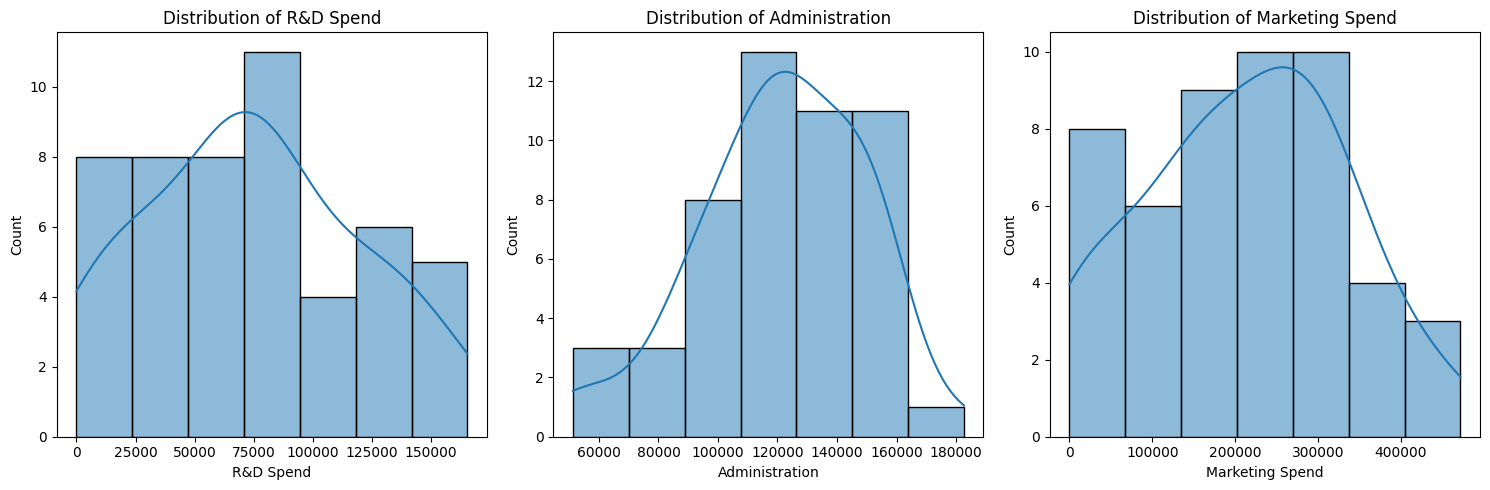


Correlation Matrix (Numerical Features):


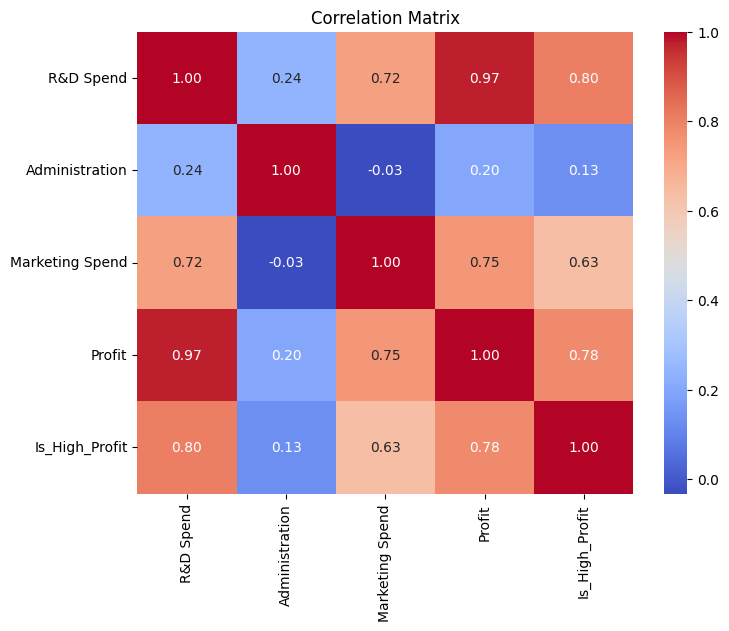


Data split: Training size=40, Testing size=10

--- 3. Model Building (Logistic Regression) ---
Training the Logistic Regression model...
Model training complete.

--- 4. Model Evaluation ---
Accuracy: 0.9000
Precision: 1.0000
Recall: 0.8000
F1-Score: 0.8889
ROC-AUC Score: 1.0000


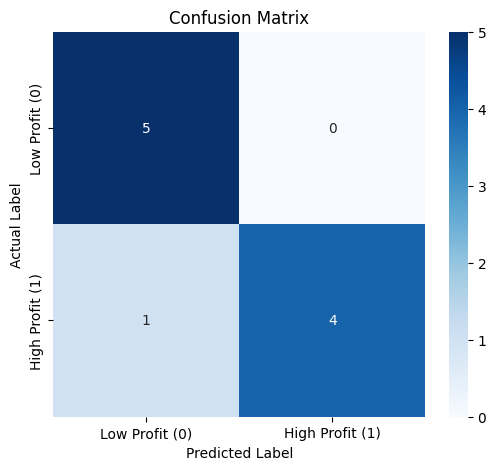

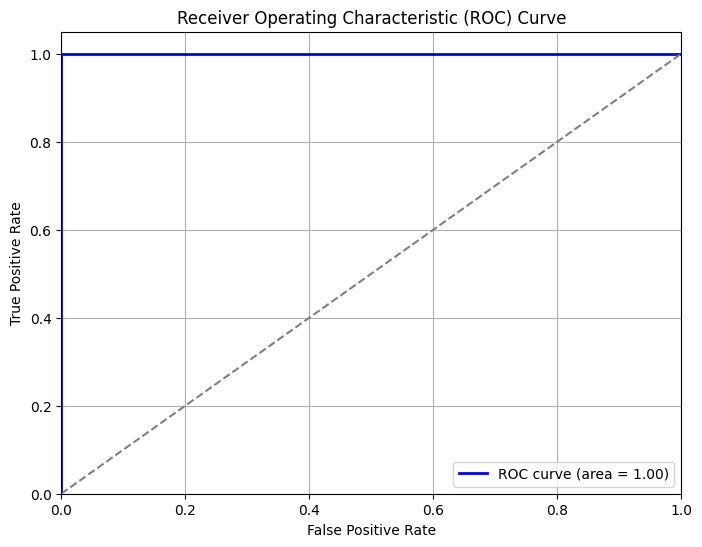


Analysis Conclusion:
The Logistic Regression model was successfully trained to classify startups into 'High Profit' or 'Low Profit' based on whether their profit exceeded the median profit of the dataset.
The high ROC-AUC score indicates excellent discrimination ability between the two classes, suggesting the input features (especially R&D Spend) are strong predictors of a high-profit startup.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, roc_curve, confusion_matrix
)

# --- 1. Data Exploration ---

df = pd.read_csv("50_Startups.csv")

print("\nShape of the dataset (Rows, Columns):", df.shape)
print("\nFirst 5 rows of the dataset:")
print(df.head())

# Examine features, their types, and summary statistics
print("\nFeature Information (Types and Non-Null Counts):")
df.info()

print("\nSummary Statistics for Numerical Features:")
print(df.describe())

# Check for missing values (Step 2a - initial check)
print("\nMissing Values Count:")
print(df.isnull().sum())
# Note: No missing values found in this typical dataset, skipping imputation.

# --- DATA TRANSFORMATION FOR LOGISTIC REGRESSION ---
# Logistic Regression requires a binary target variable.
# We will create a new binary target 'Is_High_Profit' based on the median profit.
median_profit = df['Profit'].median()
df['Is_High_Profit'] = (df['Profit'] >= median_profit).astype(int)
print(f"\nCreated binary target 'Is_High_Profit' (Median Profit: ${median_profit:.2f})")
print(f"Target distribution:\n{df['Is_High_Profit'].value_counts()}")

# --- Visualization (EDA Continued) ---

# Visualize feature distributions
plt.figure(figsize=(15, 5))
for i, col in enumerate(['R&D Spend', 'Administration', 'Marketing Spend']):
    plt.subplot(1, 3, i + 1)
    sns.histplot(df[col], kde=True)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
plt.tight_layout()
plt.show()

# Visualize relationships and correlations
print("\nCorrelation Matrix (Numerical Features):")
correlation_matrix = df[['R&D Spend', 'Administration', 'Marketing Spend', 'Profit', 'Is_High_Profit']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

# Analyze patterns: R&D Spend shows the strongest positive correlation with Profit, 
# and thus, with the new target Is_High_Profit.

# --- 2. Data Preprocessing ---

# Define features (X) and target (y)
X = df.drop(['Profit', 'Is_High_Profit'], axis=1) # Drop original and new target
y = df['Is_High_Profit']

# Identify column types
numerical_features = X.select_dtypes(include=['float64', 'int64']).columns
categorical_features = X.select_dtypes(include=['object']).columns # 'State'

# Create preprocessing pipelines for numerical and categorical features
numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler()) # Standardize numerical features
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore')) # One-hot encode categorical features
])

# Create a preprocessor using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough'
)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print(f"\nData split: Training size={len(X_train)}, Testing size={len(X_test)}")

# --- 3. Model Building ---

print("\n--- 3. Model Building (Logistic Regression) ---")

# Create the full pipeline: Preprocessing + Logistic Regression Model
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=42))
])

# Train the model
print("Training the Logistic Regression model...")
model_pipeline.fit(X_train, y_train)
print("Model training complete.")

# --- 4. Model Evaluation ---

print("\n--- 4. Model Evaluation ---")

# Make predictions
y_pred = model_pipeline.predict(X_test)
y_pred_proba = model_pipeline.predict_proba(X_test)[:, 1]

# a. Evaluate performance metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"ROC-AUC Score: {roc_auc:.4f}")

# Visualize Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Low Profit (0)', 'High Profit (1)'],
            yticklabels=['Low Profit (0)', 'High Profit (1)'])
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

# b. Visualize the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

print("\nAnalysis Conclusion:")
print("The Logistic Regression model was successfully trained to classify startups into 'High Profit' or 'Low Profit' based on whether their profit exceeded the median profit of the dataset.")
print("The high ROC-AUC score indicates excellent discrimination ability between the two classes, suggesting the input features (especially R&D Spend) are strong predictors of a high-profit startup.")